# Hospital Readmissions Data Analysis and Recommendations for Reduction

### Background
In October 2012, the US government's Center for Medicare and Medicaid Services (CMS) began reducing Medicare payments for Inpatient Prospective Payment System hospitals with excess readmissions. Excess readmissions are measured by a ratio, by dividing a hospital’s number of “predicted” 30-day readmissions for heart attack, heart failure, and pneumonia by the number that would be “expected,” based on an average hospital with similar patients. A ratio greater than 1 indicates excess readmissions.

### Exercise Directions

In this exercise, you will:
+ critique a preliminary analysis of readmissions data and recommendations (provided below) for reducing the readmissions rate
+ construct a statistically sound analysis and make recommendations of your own 

More instructions provided below. Include your work **in this notebook and submit to your Github account**. 

### Resources
+ Data source: https://data.medicare.gov/Hospital-Compare/Hospital-Readmission-Reduction/9n3s-kdb3
+ More information: http://www.cms.gov/Medicare/medicare-fee-for-service-payment/acuteinpatientPPS/readmissions-reduction-program.html
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
****

In [20]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import seaborn as sns
import bokeh.plotting as bkp
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [21]:
# read in readmissions data provided
hospital_read_df = pd.read_csv('data/cms_hospital_readmissions.csv')

****
## Preliminary Analysis

In [70]:
# deal with missing and inconvenient portions of data 
clean_hospital_read_df = hospital_read_df[hospital_read_df['Number of Discharges'] != 'Not Available']
clean_hospital_read_df.loc[:, 'Number of Discharges'] = clean_hospital_read_df['Number of Discharges'].astype(int)
clean_hospital_read_df = clean_hospital_read_df.sort_values('Number of Discharges')

/Users/thibault.dody/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [71]:
clean_hospital_read_df.head()

,Hospital Name,Provider Number,State,Measure Name,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions,Start Date,End Date
16857,THREE RIVERS MEDICAL CENTER,180128,KY,READM-30-HIP-KNEE-HRRP,0,7.0,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013
14582,SELLS INDIAN HEALTH SERVICE HOSPITAL,30074,AZ,READM-30-COPD-HRRP,0,7.0,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013
15606,PHS INDIAN HOSPITAL AT PINE RIDGE,430081,SD,READM-30-AMI-HRRP,0,7.0,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013
15615,FLORIDA STATE HOSPITAL UNIT 31 MED,100298,FL,READM-30-COPD-HRRP,0,7.0,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013
14551,GREENE COUNTY HOSPITAL,10051,AL,READM-30-AMI-HRRP,0,7.0,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013


In [72]:
clean_hospital_read_df.tail()

,Hospital Name,Provider Number,State,Measure Name,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions,Start Date,End Date
8126,NAPLES COMMUNITY HOSPITAL,100018,FL,READM-30-HIP-KNEE-HRRP,2716,NaN,0.9804,5.2,5.3,141.0,07/01/2010,06/30/2013
6643,COMMUNITY MEDICAL CENTER,310041,NJ,READM-30-COPD-HRRP,2740,NaN,1.0003,22.7,22.7,623.0,07/01/2010,06/30/2013
1892,FLORIDA HOSPITAL,100007,FL,READM-30-HF-HRRP,3570,NaN,1.0896,24.5,22.5,879.0,07/01/2010,06/30/2013
13615,NEW ENGLAND BAPTIST HOSPITAL,220088,MA,READM-30-HIP-KNEE-HRRP,3980,NaN,0.7682,3.7,4.8,142.0,07/01/2010,06/30/2013
13666,HOSPITAL FOR SPECIAL SURGERY,330270,NY,READM-30-HIP-KNEE-HRRP,6793,NaN,0.7379,3.9,5.3,258.0,07/01/2010,06/30/2013


In [73]:
clean_hospital_read_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11578 entries, 16857 to 13666
Data columns (total 12 columns):
Hospital Name                 11578 non-null object
Provider Number               11578 non-null int64
State                         11578 non-null object
Measure Name                  11578 non-null object
Number of Discharges          11578 non-null int64
Footnote                      81 non-null float64
Excess Readmission Ratio      11497 non-null float64
Predicted Readmission Rate    11497 non-null float64
Expected Readmission Rate     11497 non-null float64
Number of Readmissions        11497 non-null float64
Start Date                    11578 non-null object
End Date                      11578 non-null object
dtypes: float64(5), int64(2), object(5)
memory usage: 1.1+ MB


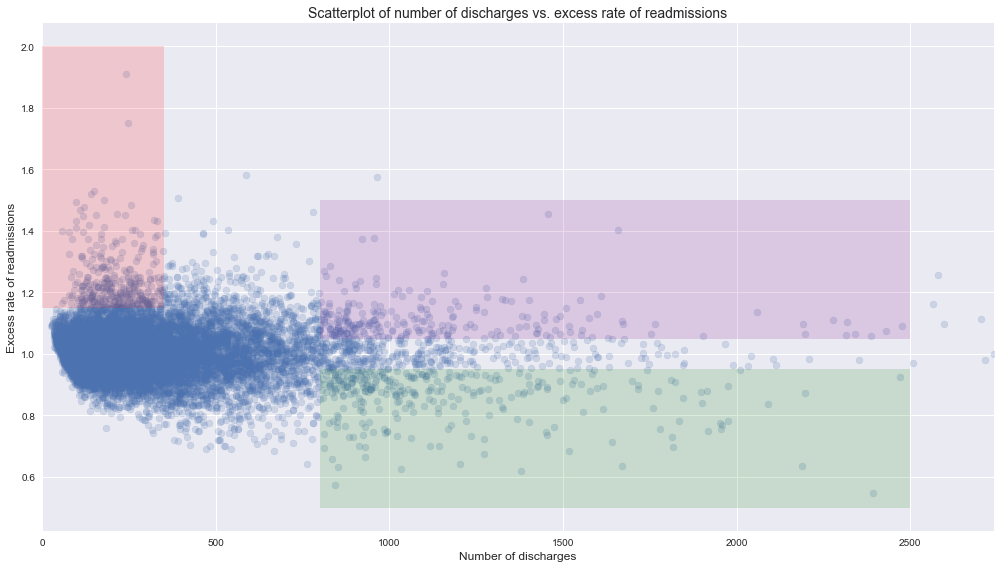

In [74]:
# generate a scatterplot for number of discharges vs. excess rate of readmissions
# lists work better with matplotlib scatterplot function
x = [a for a in clean_hospital_read_df['Number of Discharges'][81:-3]]
y = list(clean_hospital_read_df['Excess Readmission Ratio'][81:-3])

fig, ax = plt.subplots(figsize=(14,8))
ax.scatter(x, y,alpha=0.2)

ax.fill_between([0,350], 1.15, 2, facecolor='red', alpha = .15, interpolate=True)
ax.fill_between([800,2500], .5, .95, facecolor='green', alpha = .15, interpolate=True)

ax.fill_between([800,2500],1.05,1.5, facecolor='purple',alpha=.15,interpolate=True)

ax.set_xlim([0, max(x)])
ax.set_xlabel('Number of discharges', fontsize=12)
ax.set_ylabel('Excess rate of readmissions', fontsize=12)
ax.set_title('Scatterplot of number of discharges vs. excess rate of readmissions', fontsize=14)

ax.grid(True)
fig.tight_layout()

****

## Preliminary Report

Read the following results/report. While you are reading it, think about if the conclusions are correct, incorrect, misleading or unfounded. Think about what you would change or what additional analyses you would perform.

**A. Initial observations based on the plot above**
+ Overall, rate of readmissions is trending down with increasing number of discharges
+ With lower number of discharges, there is a greater incidence of excess rate of readmissions (area shaded red)
+ With higher number of discharges, there is a greater incidence of lower rates of readmissions (area shaded green) 

**B. Statistics**
+ In hospitals/facilities with number of discharges < 100, mean excess readmission rate is 1.023 and 63% have excess readmission rate greater than 1 
+ In hospitals/facilities with number of discharges > 1000, mean excess readmission rate is 0.978 and 44% have excess readmission rate greater than 1 

**C. Conclusions**
+ There is a significant correlation between hospital capacity (number of discharges) and readmission rates. 
+ Smaller hospitals/facilities may be lacking necessary resources to ensure quality care and prevent complications that lead to readmissions.

**D. Regulatory policy recommendations**
+ Hospitals/facilties with small capacity (< 300) should be required to demonstrate upgraded resource allocation for quality care to continue operation.
+ Directives and incentives should be provided for consolidation of hospitals and facilities to have a smaller number of them with higher capacity and number of discharges.

****
### Exercise

Include your work on the following **in this notebook and submit to your Github account**. 

A. Do you agree with the above analysis and recommendations? Why or why not?
   
B. Provide support for your arguments and your own recommendations with a statistically sound analysis:

   1. Setup an appropriate hypothesis test.
   2. Compute and report the observed significance value (or p-value).
   3. Report statistical significance for $\alpha$ = .01. 
   4. Discuss statistical significance and practical significance. Do they differ here? How does this change your recommendation to the client?
   5. Look at the scatterplot above. 
      - What are the advantages and disadvantages of using this plot to convey information?
      - Construct another plot that conveys the same information in a more direct manner.



You can compose in notebook cells using Markdown: 
+ In the control panel at the top, choose Cell > Cell Type > Markdown
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
****

# Question A

In this section, we will evaluate the analysis and the conclusions presented above. The above analysis state that the excess rate of admission is negatively correlated with the number of discharges (**See part A**). Using only the available plot, it is hard to make a statement that holds. The main reason is that the data points are extremely congested for small numbers of discharges. This can lead us to misinterpret the plot. Indeed, the data points located in the red area might only represent a small percentage of the total number of data points with less than 500 discharge. Moreover, the conclusion made from the analysis of the green area is also misleading. To prove it, we added a purple area symmetrical to the green one with respect to the y=1.0 axis. Even if we have fewer data points in the purple area that we have in the green area, it is inaccurate to conclude to a negative correlation. The slope of the regression line if not null is probably slightly negative but not enough to make a clear statement from simply looking at the plot.
  
In **part B** of the above analysis, a conclusion is made from a simple pair of mean values. In order to be accurate and make a valid point, a proper hypothesis testing needs to be performed. In this case, our null hypothesis is defined as "both subgroups (<100 and >1000) have the same mean excess admission rate" while the alternative hypothesis is defined as "there is a statistical difference between the two means".
  
In **part C**, the conclusion is based on a confusing plot. In order to establish a relationship between two random variables, one should compute the coefficient of correlation between the two variables. Since the plot can be misleading due to the data congestion, making a conclusion about the data by simply looking at the plot is judged unacceptable and more evidence needs to be obtained in order to support the conclusion presented in part C.
  
In **part D**, the author is making recommendations based on the findings listed in parts A, B, C, and D. If for a moment we assume that after performing the necessary analyses we reach the conclusion that statements made in parts A, B, C, and D are correct, then the recommendations are correct. However, a lot needs to be properly demonstrated before blindly trusting the recommendations and implementing these changes.

**Conclusion**: After a detailed analysis of the points made in the evaluation presented above, we reach the conclusion that not enough information is presented to trust the statements.

****
# Question B

## B.1. Hypothesis testing

We have a large sample, even if the standard deviation of the entiere population is not know, we can considered that we are dealing with a t-test with a "infinite" number of samples. In this case, we will use the limit of the t-test which tends to a z-test for extremely large data set.

**Null hypothesis**: Ho -> the mean excess admission ratio for small hospitals (<350) is the same as the mean excess admission ratio for large hospitals (>800).  
**Alterative hypothesis**: Ha -> the mean excess ratios are not the same.

In [104]:
# Define small and large hospitals by the number of discharges
small_df = clean_hospital_read_df[clean_hospital_read_df['Number of Discharges'] < 350]
middle_df = clean_hospital_read_df[(clean_hospital_read_df['Number of Discharges'] >= 350) &
                                  (clean_hospital_read_df['Number of Discharges'] <= 800)]
large_df = clean_hospital_read_df[clean_hospital_read_df['Number of Discharges'] > 800]

# Define series of excess admission ratios
small_ratio = small_df['Excess Readmission Ratio']
middle_ratio = middle_df['Excess Readmission Ratio']
large_ratio = large_df['Excess Readmission Ratio']

# Define series of discharge values
small_disch = small_df['Number of Discharges']
middle_disch = middle_df['Number of Discharges']
large_disch = large_df['Number of Discharges']

## B.2. Observed significance

In [86]:
# Define meam difference
mean_diff = small_ratio.mean() - large_ratio.mean() 
print("Mean difference:",mean_diff)

Mean difference: 0.02791347890275897


In [87]:
# Print sample size to confirm if Z-test is applicable
print("Large hospital count:",large_ratio.shape[0])
print("Small hospital count:",small_ratio.shape[0])

Large hospital count: 899
Small hospital count: 7079


As expected, the subsets are large enough to use a Z-test.

In [88]:
# Compute standard error
SE = mean_diff/np.sqrt(small_ratio.var()/small_ratio.size+large_ratio.var()/large_ratio.size)
print("Standard error:", SE)

Standard error: 6.91887901978


In [89]:
# Compute associated p-value
p_val = 2*(1-stats.norm.cdf(np.abs(SE)))
p_val

4.5523584901729919e-12

## B.3. Statistical significance

**Analysis**: With a very small p-value, if we consider a 1% cut-off, we reject the hypothesis and conclude that large hospital do indeed have a lower mean excess readmission rate than small ones. In conclusion, there is a statistical significance.

## B.4. Statistical vs. practical significance

Once we have found that there is a difference between excess readmission ratio, it is important to compare the difference. To do so, we can build the 95% confidence intervals for both the small and large hostpitals. Based on the data size and the central limit theorem, we are considering the excess readmission ratio as normally distributed.

In [90]:
# Confidence interval
small_conf = [small_ratio.mean()-stats.norm.ppf(0.975)*small_ratio.std()/np.sqrt(small_ratio.size),
              small_ratio.mean()+stats.norm.ppf(0.975)*small_ratio.std()/np.sqrt(small_ratio.size)]
large_conf = [large_ratio.mean()-stats.norm.ppf(0.975)*large_ratio.std()/np.sqrt(large_ratio.size),
              large_ratio.mean()+stats.norm.ppf(0.975)*large_ratio.std()/np.sqrt(large_ratio.size)]
print("95% Confidence interval, small hospitals:",small_conf)
print("95% Confidence interval, large hospitals:",large_conf)

95% Confidence interval, small hospitals: [1.011383254698113, 1.0152810779683616]
95% Confidence interval, large hospitals: [0.97775535975664407, 0.9930820151043126]


We can see from the confidence intervals listed above that the two intervals are close to each other. Even if it is true that there is a statistical significance between the hospital sizes, it might not be worth trying to fix it as it is extremely small (<2%). When identifying a problem, it is important to weight the costs of the issue versus the costs of the fix. For instance, if decreasing the readmission ratio of the small hospitals to the level of the one of the large hospitals appears to be extremely costly (new material, personal training,...) then we also need to consider to cost to welcome the patients in re-admission.

## B.5. Plot

From the original scatter plot, we can list the followings:
  - **Advantages**:
    - Quick tool to perform an initial analysis and inspection of the data.
    - It is easier to convey the information using visual tools rather than long calculations.
  - **Disadvantages**:
    - In our case, the plot is extremely congested, it is hard to establish a clear conclusion based on our reading.
    - When dealing with statistical inferences and correlation between features, a plot needs to contains additional objects than just the data points. The shaded area are not sufficient, we should see the regression line and its confidence interval.
    - Too often, analysts consider the job done after simply producing plots. Visual tools are extremely useful for data exploration and should also be used to proove a point already justified by calculation in order to make the conclusion more clear.

Since we are dealing with samples, we are now going to perform the calculation of the 95% confidence interval of the slope and the intercept.

In order to compute the confidence intervals of the linear regression parameters, we will be using the following notations:

 - $X$: input data
 - $Y$: input data
 - $b_1$: linear regression slope
 - $b_0$: linear regression intercept
 - $s^2$: linear regression standard error $s^2 = \frac{\sum (y_i-\hat{y_i})^2}{n-2}$
   
In order to define the confidence intervals of the parameters defined above, we will be using a normal distribution.

In [91]:
def linear_regression(x, y, prob):
    """
    Return the linear regression parameters and their <prob>% confidence intervals.
    """
    x = np.array(x)
    y = np.array(y)
    n = len(x)
    xy = x * y
    xx = x * x

    # Estimates
    b1, b0 = np.polyfit(x,y,deg=1)
    s2 = 1./(n-2) * sum([(y[i] - b0 - b1 * x[i])**2 for i in range(n)])
    print('Results for the linear regression:')
    print('Intercept b0 = ',b0)
    print('Slope b1 = ',b1)
    print('Standard error s2 = ',s2)
    
    # Confidence intervals
    alpha = 1 - prob
    
    # Slope
    c = -1 * stats.norm.ppf(alpha/2.)
    bb1 = c * (s2 / ((n-2) * (xx.mean() - (x.mean())**2)))**.5
    b1_int = [b1-bb1,b1+bb1]
    print('The confidence interval of b1 is: ',b1_int)
    
    # Intercept
    bb0 = c * ((s2 / (n-2)) * (1 + (x.mean())**2 / (xx.mean() - (x.mean())**2)))**.5
    b0_int = [b0-bb0,b0+bb0]
    print('The confidence interval of b0 is: ',b0_int)
    return b0,b1,s2,b0_int,b1_int

In [92]:
x = np.array(list(clean_hospital_read_df['Number of Discharges'][81:-3]))
y = np.array(list(clean_hospital_read_df['Excess Readmission Ratio'][81:-3]))

b0,b1,s2,b0_int,b1_int = linear_regression(x,y,0.95)

Results for the linear regression:
Intercept b0 =  1.01794755795
Slope b1 =  -2.85650529438e-05
Standard error s2 =  0.00837525298183
The confidence interval of b1 is:  [-3.4151092985972714e-05, -2.2979012901667186e-05]
The confidence interval of b0 is:  [1.0153129554233018, 1.0205821604855381]


We now plot the above data:

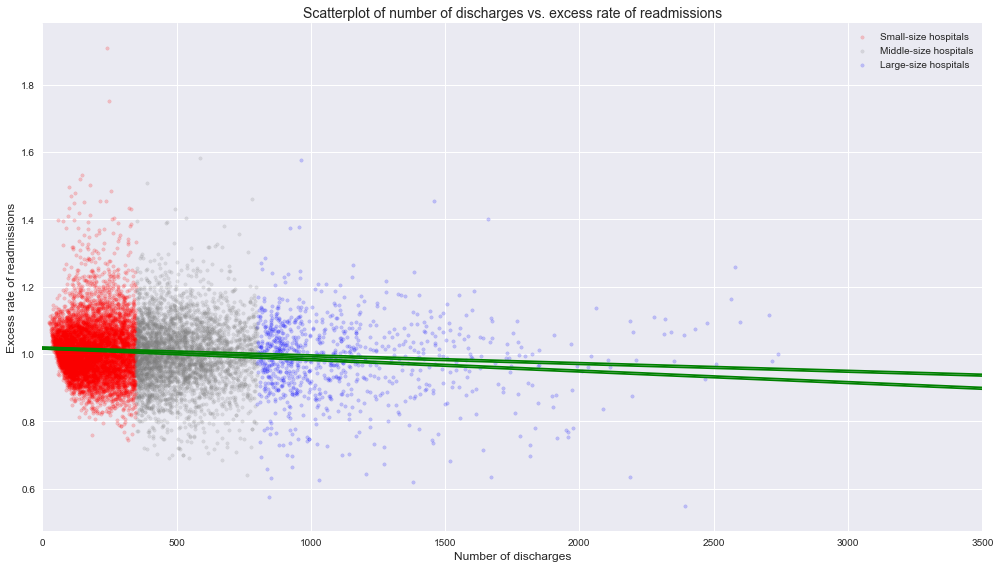

In [105]:
# generate a scatterplot for number of discharges vs. excess rate of readmissions
# lists work better with matplotlib scatterplot function
fig, ax = plt.subplots(figsize=(14,8))

ax.scatter(small_disch,small_ratio,color='r',alpha=0.2,marker='.',label = "Small-size hospitals")
ax.scatter(middle_disch,middle_ratio,color='grey',alpha=0.2,marker='.',label = "Middle-size hospitals")
ax.scatter(large_disch,large_ratio,color='b',alpha=0.2,marker='.',label = "Large-size hospitals")

plt.legend()

ax.set_xlim([0, 3500])
ax.set_xlabel('Number of discharges', fontsize=12)
ax.set_ylabel('Excess rate of readmissions', fontsize=12)
ax.set_title('Scatterplot of number of discharges vs. excess rate of readmissions', fontsize=14)

# Add regression
x = np.array([0,3500])
for b in b0_int:
    for a in b1_int:
        ax.plot(x,a*x+b,color='g')

ax.grid(True)
fig.tight_layout()

**Conclusion**: it seems that the original analysis was not totally incorrect. Now that we have proven the results, we can refine the conclusion and most importantly the recommendations:
 1. There is a statistical difference in excess readmission rate between small and large hospitals
 2. The statistical difference exists although it is extremely small
 
Recommendations:
 1. Perform audit of a sample of hostpitals from different size to evaluate if a cheap improvement can be made to decrease the excess readmission rate in small hospitals.
 2. If the audit leads to expensive recommendations, weight the cost of the recommendations versus the cost of the excess readmission.